# STFT Denoising
This is a jupyter notebook for processing of waveform data in the time-domain into STFT data.

In [1]:
import os
import numpy as np

import matplotlib.pyplot as plt

from scipy.signal import stft, istft

import tensorflow as tf
from ipywidgets import interact

from tqdm import tqdm

2023-03-27 19:26:57.061335: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1


## Load data
Load the data from the data folder

In [2]:
folder = "./data/high_snr_25/"

In [3]:
waveforms = np.load(folder + "waveforms.npy")

In [4]:
test_signal = waveforms[0]

### Already processed training data
This training data already contains (noisy) input and (denoised) target set.

In [5]:
# following the tensorflow load_data tutorial

# train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
# test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

# doesn't really work because it is not in numpy format

In [6]:
folder = "/home/alex/Desktop/Promotion/Code/Jupyter-Lab Notebooks/Waveform Denoiser/denoise_training_real/third dataset/"

In [7]:
pure_test = np.load (folder + 'pure_test_set.npy')


In [8]:
loading = False

if loading:
    pure_training = np.load(folder + "pure_training_set.npy")
    pure_test = np.load (folder + 'pure_test_set.npy')
    noisy_training = np.load(folder + 'noisy_training_set.npy')
    noisy_test = np.load(folder + 'noisy_test_set.npy')


## STFT
Short term fourier transform of a test signal

In [9]:
f,t, result_stft = stft(test_signal, fs =1/5.)


In [10]:
stfts = []
for waveform in waveforms:
    f,t, result_stft = stft(waveform, fs =1/5.)
    stfts.append(result_stft)


## Using tensorflow dataset
Tensorflows dataset class can built data from the numpy arrays of the already created noisy and pure test sets.

It just needs to be reprocessed.

See here:

This tutorial is directly applicable to my case here
https://www.tensorflow.org/tutorials/load_data/numpy
It shows how I can load numpy arrays and create a dataset from it.
Does the dataset object need to be batched?


More general information can be found here
https://www.tensorflow.org/guide/data

The last link was initially found at
https://cs230.stanford.edu/blog/datapipeline/

# need to understand what dataset batching does..
Batching is a necessary step in the numpy load tutorial.

## Processing: complex phase and amplitude split
The result of a STFT are complex data. They need to be split into separate amplitude and phase arrays.

In [11]:
class StftDataset(object):
    def __init__(self, data=None, fs = 1./5.):
        """ initialize
        """
        self.data = None
        if data is not None:
            self.process_data(data, fs=fs)
            
    def process_data(self, data, fs=1./5.):
        
        # process the data
        stfts = []
        for waveform in tqdm(data):
            f,t, result_stft = stft(waveform, fs = fs)
            stfts.append(result_stft)
            
        # store the axis parameters of the STFT (times and frequencies)
        self.f = f
        self.t = t

        # store the parameters of the 
        n = len(stfts)
        number_frequencies = stfts[0].shape[0]
        number_timeslices = stfts[0].shape[1]

        empty_data = np.zeros((n, number_frequencies, number_timeslices, 2))

        for count, current_stft in enumerate(stfts):
            amp = np.absolute(current_stft)
            phase = np.angle(current_stft)
            empty_data[count, :,:, 0] = amp
            empty_data[count, :,:, 1] = phase

        self.data = empty_data

    def save(self, folder, name):
        """ This methods saves the data under the name
        in the given folder
        """
        
        # check if data is actually available
        if self.data is None:
            print("No data stored yet.")
            return
        
        # create correct paths relative to the OS
        t_path = os.path.join(folder, name + "_t")
        f_path = os.path.join(folder, name + "_f")
        name_path = os.path.join(folder, name)
        
        # make a new folder if it already exists
        try: 
            os.mkdir(folder)
            print("Creating new folder...")
        except FileExistsError:
            print("Writing into existing folder...")
        
        # store the data
        np.save(t_path, self.t)
        np.save(f_path, self.f)
        np.save(name_path, self.data)
        
    def load(self, folder, name):
        """ This method loads the stored data (name) in 
        the given folder
        """
        # check if folder exists
        try:
            os.listdir(folder)
        except FileNotFoundError:
            print(f"Folder does not exist: {folder}")
            return

        # create correct paths relative to the OS
        t_path = os.path.join(folder, name + "_t.npy")
        f_path = os.path.join(folder, name + "_f.npy")
        name_path = os.path.join(folder, name +".npy")
        
        try:
            # load the data
            t = np.load(t_path)
            f = np.load(f_path)
            stfs = np.load(name_path)
            print("Files loaded.")
        except FileNotFoundError:
            print("Error: Files do not exist.")
            return
        
        self.t = t
        self.f = f
        self.data = stfs
            

    def get_data(self):
        return self.data

In [12]:
class DataSetBuilder(object):
    """ This class takes the base (the noisy examples) and
    the target (the denoised set) data in the time domain
    and converts it into a tensorflow dataset
    """
    def __init__(self, base, target):
        pass

In [103]:
folder = "training/new_small"
base = "noisy_small"
target = "pure_small"


In [104]:
noisy_stft = StftDataset()
pure_stft = StftDataset()

noisy_stft.load(folder, base)
pure_stft.load(folder, target)

Files loaded.
Files loaded.


In [105]:
noisy_stft.get_data().shape

(10000, 129, 9, 2)

In [106]:
index = 4290

test_noisy = noisy_stft.get_data()[index,:,:,0]
test_noisy_phase = noisy_stft.get_data()[index,:,:,1]

test_pure = pure_stft.get_data()[index,:,:,0]
test_pure_phase = pure_stft.get_data()[index,:,:,1]

In [107]:
t, signal_pure = istft(test_pure*np.exp(1j*test_pure_phase), fs = 1./5.)
t, signal_noisy = istft(test_noisy*np.exp(1j*test_noisy_phase), fs = 1./5.)

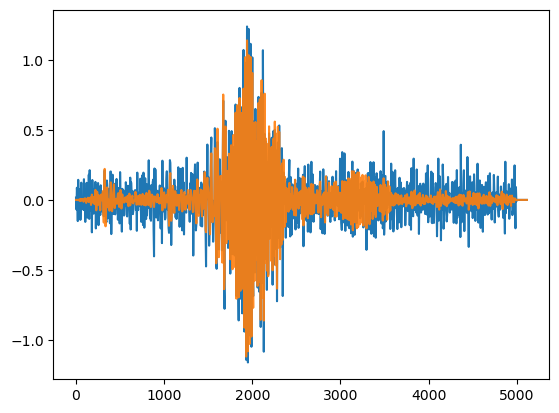

In [108]:
plt.plot(t, signal_noisy)
plt.plot(t, signal_pure, alpha=0.9)

In [111]:
def plot_index(index):

    test_noisy = noisy_stft.get_data()[index,:,:,0]
    test_noisy_phase = noisy_stft.get_data()[index,:,:,1]

    test_pure = pure_stft.get_data()[index,:,:,0]
    test_pure_phase = pure_stft.get_data()[index,:,:,1]

    t, signal_pure = istft(test_pure*np.exp(1j*test_pure_phase), fs = 1./5.)
    t, signal_noisy = istft(test_noisy*np.exp(1j*test_noisy_phase), fs = 1./5.)
    
    plt.plot(t, signal_noisy)
    plt.plot(t, signal_pure, alpha=0.9)

In [113]:
interact(plot_index, index= 1000)

interactive(children=(IntSlider(value=1000, description='index', max=3000, min=-1000), Output()), _dom_classes…

<function __main__.plot_index(index)>

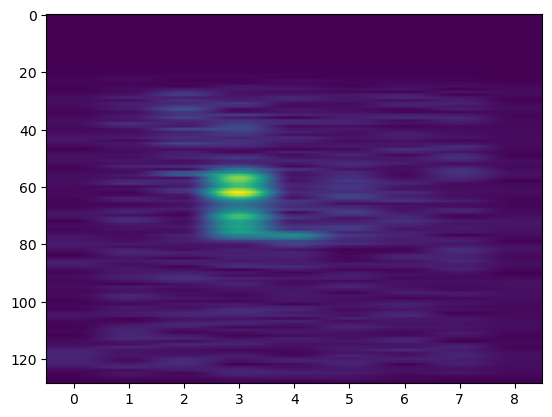

In [114]:
plt.imshow(test_noisy, aspect="auto")

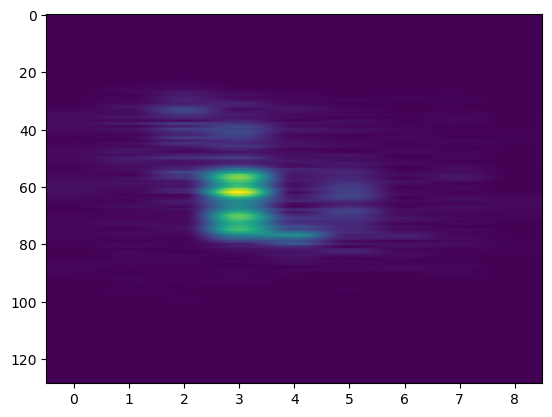

In [115]:
plt.imshow(test_pure, aspect="auto")

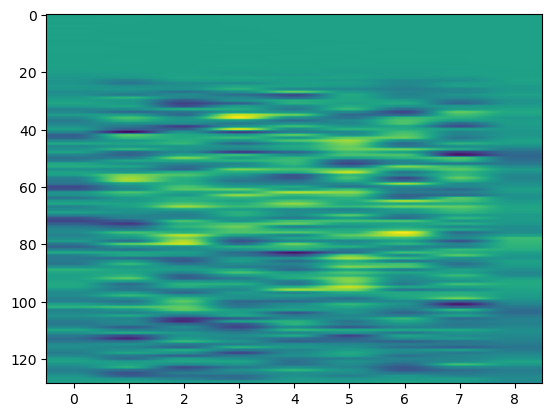

In [41]:
plt.imshow(test_pure-test_noisy, aspect="auto")

## Todo
- [ ] Separate Data Browser Tool
- [ ] Browser Tool for STFTS
- [ ] Separate code for class
- [ ] Build Model for STFTs data on small training
